In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import make_blobs
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import seaborn as sns
import matplotlib.pyplot as plt

In [93]:
centers = 2**7
n_samples = 10**4
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=centers,cluster_std=0.5, random_state= 23)

In [94]:
labels = np.random.randint(0,2,centers)

In [95]:
labels

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0])

In [96]:
target = np.array([labels[int(i)] for i in y])

In [97]:
target.mean()

0.4528

<Axes: >

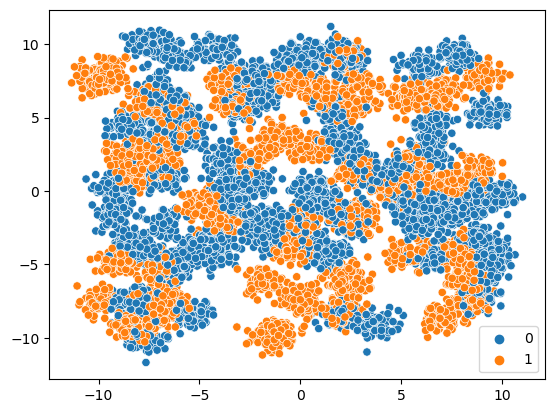

In [98]:
sns.scatterplot( x= X[:,0], y= X[:,1], hue = target)

In [8]:
class Model(nn.Module):
    def __init__(self,input_dim, hidden_dim, n_hidden= 1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_hidden = n_hidden
        modules = [nn.Linear(in_features= input_dim, out_features= hidden_dim),
            nn.ReLU()]
        for _ in range(n_hidden-1):
            modules.extend([nn.Linear(in_features= hidden_dim, out_features= hidden_dim), nn.ReLU()])
        modules.extend([nn.Linear(in_features=hidden_dim, out_features=1), nn.Sigmoid()])
        self.ff = nn.Sequential(
           *modules
        )

    def forward(self, x):
        return self.ff(x)

In [99]:
xt = torch.tensor(X, dtype= torch.float32)
yt = torch.tensor(target, dtype= torch.float32)

train, test, val = random_split([(xt[i],yt[i]) for i in range(len(xt))],lengths= [0.6,0.2,0.2])

bsize = 128
train_loader = DataLoader(train, batch_size= bsize)
test_loader = DataLoader(test, batch_size= bsize)
val_loader = DataLoader(val, batch_size= bsize)

In [313]:
model = Model(input_dim=2, hidden_dim=100, n_hidden=2)
optimizer = optim.Adam(model.parameters(), lr= 0.01)
loss_fn = nn.BCELoss()

In [10]:
def val_loss(model, data_loader, loss_fn):
    with torch.no_grad():
        losses = []
        for batch in data_loader:
            x, y = batch
            p = model(x)
            loss_ = loss_fn(p.flatten(), y)
            losses.append(loss_.item())
    return np.mean(losses)


def train_fnct(model,
               train_loader,
               val_loader,
               loss_fn,
               optimizer,
               epochs=1,
               cache_train=[],
               cache_val=[],
               verbose = 1):

    for epoch in range(epochs):
        losses = []
        for batch in train_loader:
            x, y = batch
            p = model(x)
            loss_ = loss_fn(p.flatten(), y)
            optimizer.zero_grad()
            loss_.backward()
            # update weights
            optimizer.step()
            losses.append(loss_.item())

        val_loss_ = val_loss(model, val_loader, loss_fn)
        if verbose == 1:
            print(f'Epoch {epoch}: ', np.mean(losses), f' Val loss: {val_loss_}')
        cache_train.append(np.mean(losses))
        cache_val.append(val_loss_)

In [280]:
cache_train = []
cache_val = []
train_fnct(model, train_loader,val_loader, loss_fn, optimizer, epochs=150, cache_train=cache_train, cache_val= cache_val)

Epoch 0:  0.3015539986973113  Val loss: 0.30109285842627287
Epoch 1:  0.2844011942122845  Val loss: 0.29922668263316154
Epoch 2:  0.2848414691521766  Val loss: 0.29213910829275846
Epoch 3:  0.28318845179486785  Val loss: 0.2922290312126279
Epoch 4:  0.2824854370444379  Val loss: 0.2929634968750179
Epoch 5:  0.2807035752116366  Val loss: 0.29371619457378983
Epoch 6:  0.28079552203416824  Val loss: 0.2872264510951936
Epoch 7:  0.28012381383079166  Val loss: 0.28670605132356286
Epoch 8:  0.27958755242697736  Val loss: 0.2865283852443099
Epoch 9:  0.28055690308200554  Val loss: 0.2879744255915284
Epoch 10:  0.2792416046908561  Val loss: 0.2861829693429172
Epoch 11:  0.2790117398538488  Val loss: 0.2837182404473424
Epoch 12:  0.27859498132416544  Val loss: 0.28323127469047904
Epoch 13:  0.27854567877155667  Val loss: 0.2832235195674002
Epoch 14:  0.278456892897474  Val loss: 0.28312098467722535
Epoch 15:  0.2781520183099077  Val loss: 0.2834250279702246
Epoch 16:  0.27818161455240653  Val l

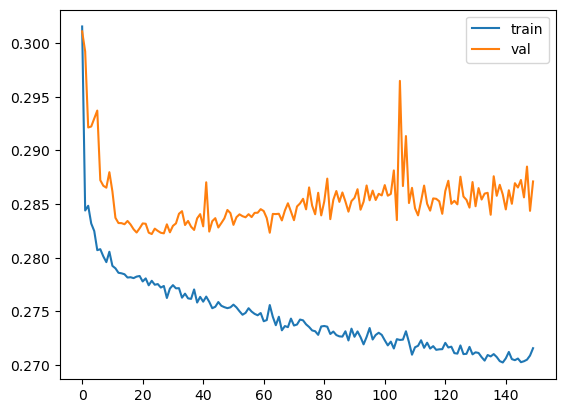

In [281]:
plt.plot(cache_train, label ='train')
plt.plot(cache_val, label='val')
plt.legend()

# loop

In [100]:
val_best = []
hidden_dims = np.arange(2,300,1)
for dim in tqdm(hidden_dims):
    model = Model(input_dim=2, hidden_dim=dim, n_hidden=2)
    optimizer = optim.Adam(model.parameters(), lr= 0.01)
    loss_fn = nn.BCELoss()

    cache_train = []
    cache_val = []

    train_fnct(model, train_loader,val_loader, loss_fn, optimizer, epochs=50, cache_train=cache_train, cache_val= cache_val, verbose= 0 )

    val_best.append(min(cache_val))

100%|██████████| 298/298 [07:58<00:00,  1.61s/it]


In [101]:
np.array(val_best).min()

0.40112611651420593

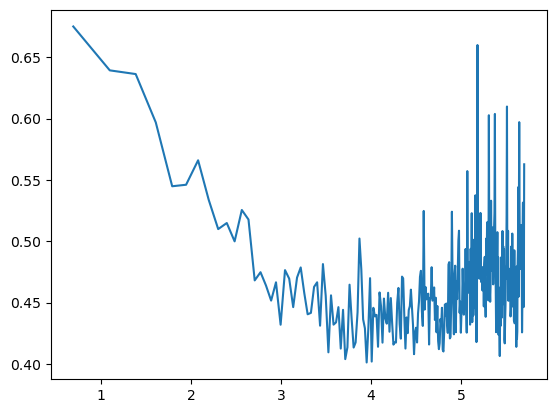

In [102]:
plt.plot(np.log(hidden_dims[:]), val_best[:])